PPP (with BM3D) Image Demosaicing
=================================

This example demonstrates the use of the ADMM Plug and Play Priors (PPP)
algorithm <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, with the BM3D
<cite data-cite="dabov-2008-image"/> denoiser, for solving a raw image demosaicing
problem.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

import numpy as np

from bm3d import bm3d_rgb

# Workarounds for colour_demosaicing incompatibility with NumPy 2.x
np.float_ = np.float64
np.float = np.float64
np.complex = np.complex128
np.sctypes = {
    "float": [np.float16, np.float32, np.float64, np.longdouble],
    "int": [np.int8, np.int16, np.int32, np.int64],
}
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

import scico
import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.data import kodim23
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info

Read a ground truth image.

In [2]:
img = snp.array(kodim23(asfloat=True)[160:416, 60:316])

Define demosaicing forward operator and its transpose.

In [3]:
def Afn(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = snp.zeros(x.shape[0:2])
    y = y.at[1::2, 1::2].set(x[1::2, 1::2, 0])
    y = y.at[0::2, 1::2].set(x[0::2, 1::2, 1])
    y = y.at[1::2, 0::2].set(x[1::2, 0::2, 1])
    y = y.at[0::2, 0::2].set(x[0::2, 0::2, 2])
    return y


def ATfn(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = snp.zeros(x.shape + (3,))
    y = y.at[1::2, 1::2, 0].set(x[1::2, 1::2])
    y = y.at[0::2, 1::2, 1].set(x[0::2, 1::2])
    y = y.at[1::2, 0::2, 1].set(x[1::2, 0::2])
    y = y.at[0::2, 0::2, 2].set(x[0::2, 0::2])
    return y

Define a baseline demosaicing function based on the demosaicing
algorithm of <cite data-cite="menon-2007-demosaicing"/> from package
[colour_demosaicing](https://github.com/colour-science/colour-demosaicing).

In [4]:
def demosaic(cfaimg):
    """Apply baseline demosaicing."""
    return demosaicing_CFA_Bayer_Menon2007(cfaimg, pattern="BGGR").astype(np.float32)

Create a test image by color filter array sampling and adding Gaussian
white noise.

In [5]:
s = Afn(img)
rgbshp = s.shape + (3,)  # shape of reconstructed RGB image
σ = 2e-2  # noise standard deviation
noise, key = scico.random.randn(s.shape, seed=0)
sn = s + σ * noise

Compute a baseline demosaicing solution.

In [6]:
imgb = snp.array(bm3d_rgb(demosaic(sn), 3 * σ).astype(np.float32))

Set up an ADMM solver object. Note the use of the baseline solution
as an initializer. We use BM3D <cite data-cite="dabov-2008-image"/> as the
denoiser, using the [code](https://pypi.org/project/bm3d) released
with <cite data-cite="makinen-2019-exact"/>.

In [7]:
A = linop.LinearOperator(input_shape=rgbshp, output_shape=s.shape, eval_fn=Afn, adj_fn=ATfn)
f = loss.SquaredL2Loss(y=sn, A=A)
C = linop.Identity(input_shape=rgbshp)
g = 1.8e-1 * 6.1e-2 * functional.BM3D(is_rgb=True)
ρ = 1.8e-1  # ADMM penalty parameter
maxiter = 12  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=imgb,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True},
)

Run the solver.

In [8]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  5.10e+00  2.449e+00  4.165e-01      1  1.555e-09


   1  8.60e+00  2.022e+00  1.539e-01      2  1.292e-09


   2  1.20e+01  1.523e+00  2.007e-01      2  1.882e-09


   3  1.57e+01  1.161e+00  2.688e-01      2  1.097e-09


   4  1.92e+01  9.403e-01  2.788e-01      2  8.013e-10


   5  2.26e+01  8.296e-01  2.338e-01      2  6.078e-10


   6  2.59e+01  7.445e-01  1.659e-01      2  7.613e-10


   7  2.92e+01  5.958e-01  8.403e-02      1  8.486e-04


   8  3.27e+01  5.171e-01  1.298e-01      2  2.509e-10


   9  3.61e+01  4.234e-01  1.287e-01      2  2.363e-10


  10  3.95e+01  3.756e-01  1.234e-01      2  2.749e-10


  11  4.29e+01  2.722e-01  7.911e-02      1  9.790e-04


Show reference and demosaiced images.

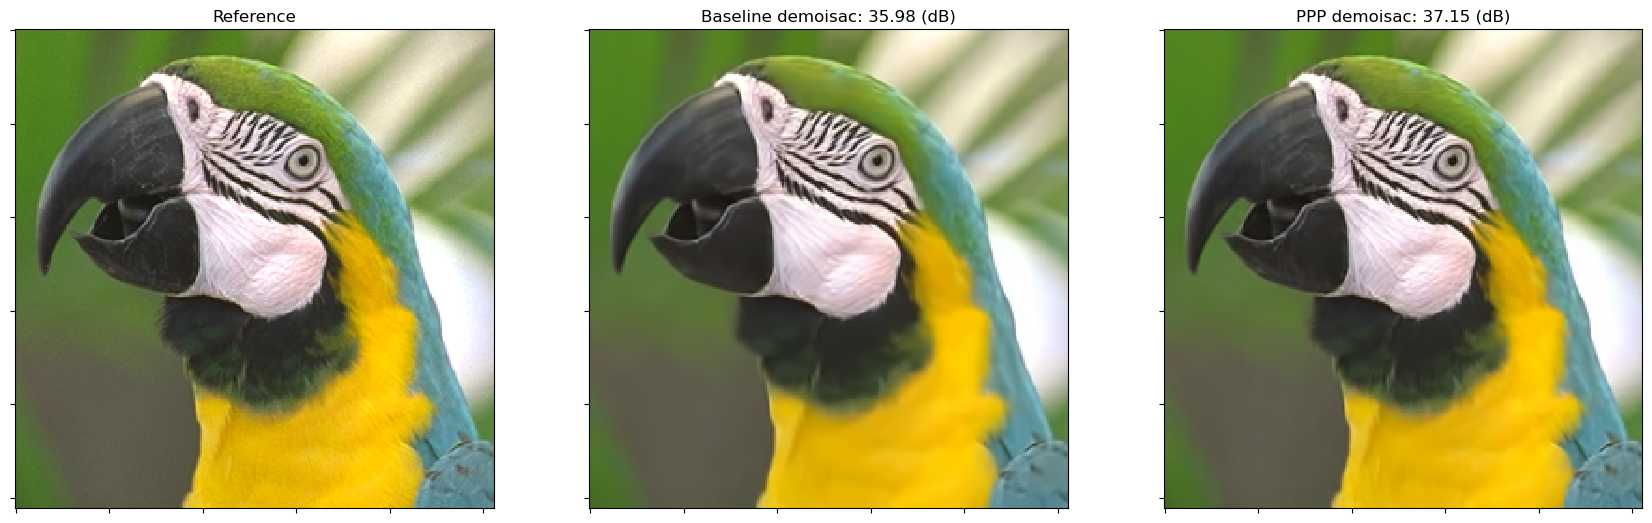

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(img, title="Reference", fig=fig, ax=ax[0])
plot.imview(imgb, title="Baseline demoisac: %.2f (dB)" % metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(x, title="PPP demoisac: %.2f (dB)" % metric.psnr(img, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals'}, xlabel='Iteration'>)

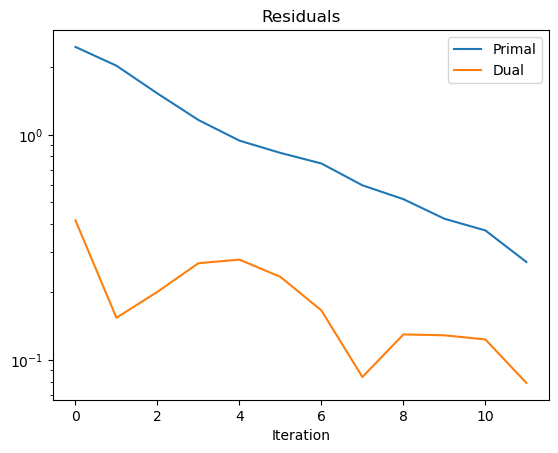

In [10]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)